**Assignment Objective:**

Consider the QWorld environment from your first assignment. The objective of this assignment is to design a agent that learn how to solve this problem through the **sarsamax (Q-learning)** and **sarsa** algorithms seen in class

Provide your answers for **PART1** and **PART2** in this notebook and submit it before the due date.

In [1]:
"""Q Learning to solve a simple world model

Simple deterministic MDP is made of 6 grids (states)
---------------------------------
|         |          |          |
|  Start  |          |  Goal    |
|         |          |          |
---------------------------------
|         |          |          |
|         |          |  Hole    |
|         |          |          |
---------------------------------

"""

from collections import deque
import numpy as np
import argparse
import os
import time
from termcolor import colored


class QWorld:
    def __init__(self):
        """Simulated deterministic world made of 6 states.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = 4

        # 6 states
        self.row = 6

        # setup the environment
        self.init_transition_table()
        self.init_reward_table()

        # reset the environment
        self.reset()

    def reset(self):
        """start of episode"""
        self.state = 0
        self.count = 0
        return self.state

    def is_in_win_state(self):
        """agent wins when the goal is reached"""
        return self.state == 2


    def init_reward_table(self):
        """
        0 - Left, 1 - Down, 2 - Right, 3 - Up
        ----------------
        | 0 | 0 | 100  |
        ----------------
        | 0 | 0 | -100 |
        ----------------
        """
        self.reward_table = np.zeros([self.row, self.col])
        self.reward_table[1, 2] = 100.
        self.reward_table[4, 2] = -100.


    def init_transition_table(self):
        """
        0 - Left, 1 - Down, 2 - Right, 3 - Up
        -------------
        | 0 | 1 | 2 |
        -------------
        | 3 | 4 | 5 |
        -------------
        """
        self.transition_table = np.zeros([self.row, self.col],
                                         dtype=int)

        self.transition_table[0, 0] = 0
        self.transition_table[0, 1] = 3
        self.transition_table[0, 2] = 1
        self.transition_table[0, 3] = 0

        self.transition_table[1, 0] = 0
        self.transition_table[1, 1] = 4
        self.transition_table[1, 2] = 2
        self.transition_table[1, 3] = 1

        # terminal Goal state
        self.transition_table[2, 0] = 2
        self.transition_table[2, 1] = 2
        self.transition_table[2, 2] = 2
        self.transition_table[2, 3] = 2

        self.transition_table[3, 0] = 3
        self.transition_table[3, 1] = 3
        self.transition_table[3, 2] = 4
        self.transition_table[3, 3] = 0

        self.transition_table[4, 0] = 3
        self.transition_table[4, 1] = 4
        self.transition_table[4, 2] = 5
        self.transition_table[4, 3] = 1

        # terminal Hole state
        self.transition_table[5, 0] = 5
        self.transition_table[5, 1] = 5
        self.transition_table[5, 2] = 5
        self.transition_table[5, 3] = 5


    def step(self, action):
        """execute the action on the environment
        Argument:
            action (tensor): An action in Action space
        Returns:
            next_state (tensor): next env state
            reward (float): reward received by the agent
            done (Bool): whether the terminal state
                is reached
        """
        # determine the next_state given state and action
        next_state = self.transition_table[self.state, action]
        # done is True if next_state is Goal or Hole
        done = next_state == 2 or next_state == 5
        # reward given the state and action
        reward = self.reward_table[self.state, action]
        # the enviroment is now in new state
        self.state = next_state
        self.count+=1
        return next_state, reward, done




    def print_cell(self, row=0):
        """UI to display agent moving on the grid"""
        print("")
        for i in range(13):
            j = i - 2
            if j in [0, 4, 8]:
                if j == 8:
                    if self.state == 2 and row == 0:
                        marker = "\033[4mG\033[0m"
                    elif self.state == 5 and row == 1:
                        marker = "\033[4mH\033[0m"
                    else:
                        marker = 'G' if row == 0 else 'H'
                    color = self.state == 2 and row == 0
                    color = color or (self.state == 5 and row == 1)
                    color = 'red' if color else 'blue'
                    print(colored(marker, color), end='')
                elif self.state in [0, 1, 3, 4]:
                    cell = [(0, 0, 0), (1, 0, 4), (3, 1, 0), (4, 1, 4)]
                    marker = '_' if (self.state, row, j) in cell else ' '
                    print(colored(marker, 'red'), end='')
                else:
                    print(' ', end='')
            elif i % 4 == 0:
                    print('|', end='')
            else:
                print(' ', end='')
        print("")


    def print_world(self, action, step,is_explore):
        """UI to display mode and action of agent"""
        actions = { 0: "(Left)", 1: "(Down)", 2: "(Right)", 3: "(Up)" }
        explore = "Explore" if is_explore else "Exploit"
        print("Step", step, ":", explore, actions[action])
        for _ in range(13):
            print('-', end='')
        self.print_cell()
        for _ in range(13):
            print('-', end='')
        self.print_cell(row=1)
        for _ in range(13):
            print('-', end='')
        print("")




In [2]:
def print_episode(episode, delay=1):
    """UI to display episode count
    Arguments:
        episode (int): episode number
        delay (int): sec delay

    """
    os.system('clear')
    for _ in range(13):
        print('=', end='')
    print("")
    print("Episode ", episode)
    for _ in range(13):
        print('=', end='')
    print("")
    time.sleep(delay)


def print_status(q_world,q_agent, done, step, delay=1):
    """UI to display the world,
        delay of 1 sec for ease of understanding
    """
    os.system('clear')
    q_world.print_world(action, step,q_agent.is_explore)
    q_agent.print_q_table()
    if done:
        print("-------EPISODE DONE--------")
        delay *= 2
    time.sleep(delay)

# **PART1**: SARSAMAX agent (off-policy)


## a) complete the TODO parts in the cell below in order to design an agent that learns through Q-learning

In [3]:
class QAgent:
    def __init__(self, col, row, alpha):
        """Q-Learning based agent by Bellman Equation.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = col

        # 6 states
        self.row = row

        # initialize the q table
        self.q_table = np.zeros([self.row, self.col])

        # discount factor
        self.gamma = 0.9

        # learning rate
        self.alpha = alpha

        # 90% exploration, 10% exploitation
        self.epsilon = 0.9
        # exploration decays by this factor every episode
        self.epsilon_decay = 0.9
        # in the long run, 10% exploration, 90% exploitation
        self.epsilon_min = 0

        # set action model to exploration
        self.is_explore = True

    def act(self, state):
        """determine the next action
            either for Q Table(exploitation) or
            random(exploration)
        Return:
            action (tensor): action that the agent
                must execute
        """
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        # action based on exploration
        if np.random.rand() <= self.epsilon:
            ##################################################
            #TODO set exploration mode to true and
            # take random action
            ##################################################
             # Exploration: Choose a random action
            self.is_explore = True
            action = np.random.randint(self.col)

        else:
            ##################################################
            #TODO set exploration mode to false and
            # take greedy action
            ##################################################
            # Exploitation: Choose the best action based on the current Q-table
            self.is_explore = False
            action = np.argmax(self.q_table[state])
        return action


        return action

    def update_q_table(self, state, action, reward, next_state):
        """Q-Learning - update the Q Table using Q(s, a)
        Arguments:
            state (tensor) : agent state
            action (tensor): action executed by the agent
            reward (float): reward after executing action
                for a given state
            next_state (tensor): next state after executing
                action for a given state
        """
        ########################################################
        #TODO update the Q-table with blended Bellman update rule
        ########################################################
    def update_q_table(self, state, action, reward, next_state):
        # Q-Learning update rule
        best_next_action = np.argmax(self.q_table[next_state])  # Best action for next_state
        td_target = reward + self.gamma * self.q_table[next_state, best_next_action]
        td_delta = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * td_delta

    def print_q_table(self):
        """UI to dump Q Table contents"""
        print("Q-Table (Epsilon: %0.2f)" % self.epsilon)
        print(self.q_table)

    def update_epsilon(self):
        """update Exploration-Exploitation mix"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



## b) complete the TODO parts in the cell below order to implement a training loop

Recall the steps seen in class:
1. Start with an empty table for $Q(s, a)$.
2. Obtain $(s, a, r, s')$ from the environment.
3. Make a Bellman update: $𝑄(𝑠, 𝑎) ← (1 − 𝛼)𝑄(𝑠, 𝑎) + 𝛼 (𝑟 + 𝛾\max\limits_{x'\in A} Q(s',a'))$
4. Check convergence conditions. If not met, repeat from step 2.

In [4]:
delay = 0
wins = 0
episode_count = 10000

##################################################
#TODO instantiate an environment q_world
# and an agent called q_agent
##################################################
# Instantiate environment and agent
q_world = QWorld()
q_agent = QAgent(q_world.col, q_world.row, alpha=0.1)  # Adjust alpha as needed

#count the number of iterations
iterations=0

np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)

    while not done:
        # Choose an action based on the current state
        action = q_agent.act(state)

        # Obtain next_state, reward, and whether the episode is done from the environment
        next_state, reward, done = q_world.step(action)

        # Update the Q-table with the new information
        q_agent.update_q_table(state, action, reward, next_state)

        # Update state for the next iteration
        state = next_state

        iterations += 1

        # Check if the episode is finished
        if done:
            if q_world.is_in_win_state():
                wins += 1

            percent_wins = 100.0 * wins / (episode + 1)
            print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))

            # Update exploration rate every episode
            q_agent.update_epsilon()

    # Check if convergence condition is met
    if (episode > 100) & (percent_wins >= 99.5):
        print("solved in %d iterations" % iterations)
        break


Episode  0
-------0.00% Goals in 0 Episodes---------
Episode  1
-------0.00% Goals in 1 Episodes---------
Episode  2
-------33.33% Goals in 2 Episodes---------
Episode  3
-------50.00% Goals in 3 Episodes---------
Episode  4
-------60.00% Goals in 4 Episodes---------
Episode  5
-------66.67% Goals in 5 Episodes---------
Episode  6
-------71.43% Goals in 6 Episodes---------
Episode  7
-------75.00% Goals in 7 Episodes---------
Episode  8
-------77.78% Goals in 8 Episodes---------
Episode  9
-------80.00% Goals in 9 Episodes---------
Episode  10
-------81.82% Goals in 10 Episodes---------
Episode  11
-------75.00% Goals in 11 Episodes---------
Episode  12
-------76.92% Goals in 12 Episodes---------
Episode  13
-------78.57% Goals in 13 Episodes---------
Episode  14
-------80.00% Goals in 14 Episodes---------
Episode  15
-------81.25% Goals in 15 Episodes---------
Episode  16
-------82.35% Goals in 16 Episodes---------
Episode  17
-------83.33% Goals in 17 Episodes---------
Episode  18
--

### c) Based on the the cell above, when is the problem considered solved? And, after how many iterations the problem was actually solved?
### **(indicate answer in text cell  here)**
The problem is considered solved when the agent successfully reaches the goal in at least 99.5% of the episodes.
The problem is considered solved at the point when the agent's performance (percent of wins or successful goal reaches) crosses the 99.5% threshold.

### d) Provide a plot of the percent_wins as a function of the iterations (i.

---

e., iteration number on the x-axis and corresponding percent_wins in the y-axis)

---



Episode  0
-------70000.00% Goals in 0 Episodes---------
Episode  1
-------35050.00% Goals in 1 Episodes---------
Episode  2
-------23400.00% Goals in 2 Episodes---------
Episode  3
-------17575.00% Goals in 3 Episodes---------
Episode  4
-------14080.00% Goals in 4 Episodes---------
Episode  5
-------11750.00% Goals in 5 Episodes---------
Episode  6
-------10085.71% Goals in 6 Episodes---------
Episode  7
-------8837.50% Goals in 7 Episodes---------
Episode  8
-------7866.67% Goals in 8 Episodes---------
Episode  9
-------7090.00% Goals in 9 Episodes---------
Episode  10
-------6454.55% Goals in 10 Episodes---------
Episode  11
-------5925.00% Goals in 11 Episodes---------
Episode  12
-------5476.92% Goals in 12 Episodes---------
Episode  13
-------5092.86% Goals in 13 Episodes---------
Episode  14
-------4760.00% Goals in 14 Episodes---------
Episode  15
-------4468.75% Goals in 15 Episodes---------
Episode  16
-------4211.76% Goals in 16 Episodes---------
Episode  17
-------3983.33%

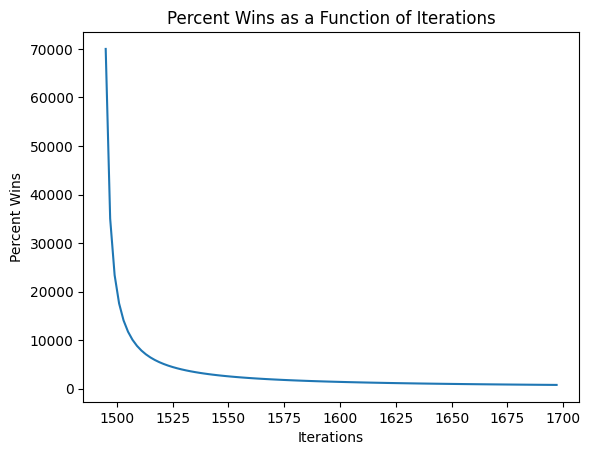

In [6]:
iterations_list = []
percent_wins_list = []
for episode in range(episode_count):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)

    while not done:
        # Choose an action based on the current state
        action = q_agent.act(state)

        # Obtain next_state, reward, and whether the episode is done from the environment
        next_state, reward, done = q_world.step(action)

        # Update the Q-table with the new information
        q_agent.update_q_table(state, action, reward, next_state)

        # Update state for the next iteration
        state = next_state

        iterations += 1

    if done:
        # ... existing code for checking win state ...
        if q_world.is_in_win_state():
                wins += 1

        percent_wins = 100.0 * wins / (episode + 1)
        print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))

            # Update exploration rate every episode
        q_agent.update_epsilon()

        iterations_list.append(iterations)
        percent_wins_list.append(percent_wins)

    # Check if convergence condition is met
    if (episode > 100) & (percent_wins >= 99.5):
        print("solved in %d iterations" % iterations)
        break
import matplotlib.pyplot as plt

plt.plot(iterations_list, percent_wins_list)
plt.xlabel('Iterations')
plt.ylabel('Percent Wins')
plt.title('Percent Wins as a Function of Iterations')
plt.show()



\\### e) Print the final Q-table (after training loop ends)

In [7]:
print("Final Q-Table:")
print(q_agent.q_table)


Final Q-Table:
[[  0.600777     0.          90.           0.        ]
 [  0.600777     2.54337213 100.          16.13991943]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.351459     0.        ]
 [  0.           0.351459   -27.1         21.02568763]
 [  0.           0.           0.           0.        ]]


### f) Based on this final table, what is the best action to take if the agent is in state 3?
### **(add answer in text cell here)**
the highest Q-value is 0.351459, which corresponds to action 2.

### g) Finally, now use your trained agent in 20 episodes-- full exploitation
### Use `print_status` for showing episode results

### Then, provide a plot that shows whether the agent reached the goal or not as a function of the episodes (i.e, x-axis is episode number, y-axis: 1 if goal reached, 0 otherwise)

### Comment on the obtained results.
### What is the percent wins  for these 20 episodes?

Step 0 : Exploit (Right)
-------------
|   | _ | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[  0.600777     0.          90.           0.        ]
 [  0.600777     2.54337213 100.          16.13991943]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.351459     0.        ]
 [  0.           0.351459   -27.1         21.02568763]
 [  0.           0.           0.           0.        ]]
Step 0 : Exploit (Right)
-------------
|   |   | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[  0.600777     0.          90.           0.        ]
 [  0.600777     2.54337213 100.          16.13991943]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.351459     0.        ]
 [  0.           0.351459   -27.1         21.02568763]
 [  0.           0.           0.           0.        ]]
-------EPISODE DONE--------
Step 1 : Exploit (Right)
-------------
|   | _ | G |
-------------
|   |

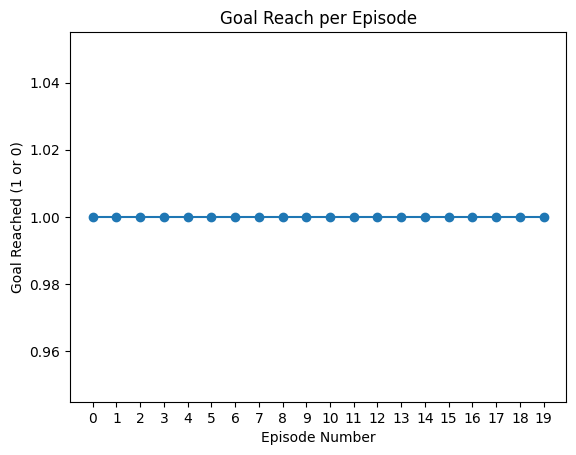

Percent wins for these 20 episodes: 100.0%


In [8]:
episode_results = []  # Store whether the goal is reached in each episode (1 for success, 0 for failure)

for episode in range(20):
    state = q_world.reset()
    done = False

    while not done:
        # Choose the best action from the Q-table
        action = np.argmax(q_agent.q_table[state])
        next_state, reward, done = q_world.step(action)

        # Update state
        state = next_state

        # Print status if desired
        print_status(q_world, q_agent, done, episode)

        if done:
            # Record if the goal was reached
            episode_results.append(1 if q_world.is_in_win_state() else 0)
import matplotlib.pyplot as plt

plt.plot(range(20), episode_results, marker='o')
plt.xlabel('Episode Number')
plt.ylabel('Goal Reached (1 or 0)')
plt.title('Goal Reach per Episode')
plt.xticks(range(20))  # Set x-axis ticks to show each episode
plt.show()
percent_wins = 100 * sum(episode_results) / 20
print(f"Percent wins for these 20 episodes: {percent_wins}%")


# **PART2**: SARSA-based agent (ON-policy)
# In this part, you need to implement an agent that learns how to solve this problem with the on-policy sarsa algorithm. Re-answer all the questions as in part A):  from a) to g)

In [24]:
class SARSAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.9, epsilon=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.q_table[state, :])

    def update(self, state, action, reward, new_state, new_action):
    # Check if new_state is terminal
       if new_action is None:
         future_value = 0
       else:
         future_value = self.q_table[new_state, new_action]

       target = reward + self.gamma * future_value
       self.q_table[state, action] += self.alpha * (target - self.q_table[state, action])


    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * 0.99, 0.01)  # Adjust decay rate and min epsilon as needed

### Function to Calculate Success Rate

    def calculate_success_rate(env, agent, num_trials):
        successes = 0
        for _ in range(num_trials):
           state = env.reset()
           done = False
           while not done:
              action = np.argmax(agent.q_table)



In [25]:
# Assuming the environment (env) and SARSA agent (agent) are initialized
num_episodes = 1000
# Initialize the environment
env = QWorld()

# Initialize the SARSA agent
# Assuming QWorld has 6 states and 4 actions
state_size = 6
action_size = 4

agent = SARSAgent(state_size=state_size, action_size=action_size, alpha=0.1, gamma=0.9, epsilon=1.0)

for episode in range(num_episodes):
    state = env.reset()
    action = agent.choose_action(state)
    done = False

    while not done:
        new_state, reward, done = env.step(action)
        new_action = agent.choose_action(new_state) if not done else None

        agent.update(state, action, reward, new_state, new_action)

        state = new_state
        action = new_action

    agent.decay_epsilon()


In [ ]:

### Training Loop and Plotting Success Rates

import matplotlib.pyplot as plt
import numpy as np
def calculate_success_rate(env, agent, num_trials):
        successes = 0
        for _ in range(num_trials):
           state = env.reset()
           done = False
           while not done:
              action = np.argmax(agent.q_table)
# Assuming the environment (env) and SARSA agent (agent) are initialized
num_episodes = 50
success_rates = []

for episode in range(num_episodes):
    state = env.reset()
    action = agent.choose_action(state)
    done = False

    while not done:
        new_state, reward, done = env.step(action)
        new_action = agent.choose_action(new_state) if not done else None
        agent.update(state, action, reward, new_state, new_action)
        state, action = new_state, new_action

    agent.decay_epsilon()

    if episode % 10 == 0:  # Evaluate success rate every 10 episodes
        success_rate = calculate_success_rate(env, agent, 10)
        success_rates.append(success_rate)

# Plotting
plt.plot(range(0, num_episodes, 10), success_rates)
plt.xlabel('Episodes')
plt.ylabel('Success Rate')
plt.title('Success Rate over Episodes')
plt.show()


In [32]:
print("Final Q-Table Values")
print(agent.q_table)


Final Q-Table Values
[[ 5.77084716e+01  3.16279169e+01  8.98869345e+01  5.05745572e+01]
 [ 5.52885734e+01  5.19674470e+01  1.00000000e+02  7.82049411e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.36450790e+00  1.21930620e+00 -6.46501707e-02  6.10935441e+01]
 [-6.39575966e-02 -2.89389367e+00 -6.86189404e+01  8.03665077e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [34]:
state = 3  # Example state
best_action = np.argmax(agent.q_table[state, :])
print("Best action for state {}: {}".format(state, best_action))


Best action for state 3: 3


In [35]:
total_episodes = 20
successes = 0

for episode in range(total_episodes):
    state = env.reset()
    done = False

    while not done:
        action = np.argmax(agent.q_table[state, :])  # Always choose the best action
        new_state, reward, done = env.step(action)
        state = new_state
        if done and reward > 0:  # Assuming positive reward for success
            successes += 1

print("Success rate: {:.2f}%".format(100 * successes / total_episodes))


Success rate: 100.00%
